# Importing the libraries

In [7]:
# Import the libraries
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import random
import umap
import time
from pathlib import Path

def load_images(path):
    # Load mapping.txt, train.txt and test.txt files
    mapping_file = os.path.join(path, 'mapping.txt')
    with open(mapping_file, 'r') as f:
      mapping = {line.split()[0]: int(line.split()[1]) for line in f.readlines()}

    train_file = os.path.join(path, 'train.txt')
    with open(train_file, 'r') as f:
      train_data = [line.strip().split() for line in f.readlines()]

    test_file = os.path.join(path, 'test.txt')
    with open(test_file, 'r') as f:
      test_data = [line.strip().split() for line in f.readlines()]

    # Print sample of train and test data
    print(f"Train Data Sample: {train_data[:5]}")
    print(f"Test Data Sample: {test_data[:5]}")
    
    return mapping, train_data, test_data

def plot_class_distribution(labels, num_classes=10, title="Class Distribution Histogram"):
    """
    Plots a histogram of the class distribution in the dataset.
    
    Parameters:
    - labels (list): List of class labels (e.g., [0, 1, 0, 3, 5, 2, ...]).
    - num_classes (int): Number of classes in the dataset (default is 10 for your dataset).
    - title (str): The title of the plot.
    """
    # Count the occurrences of each class
    class_counts = [labels.count(i) for i in range(num_classes)]
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_classes), class_counts, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(range(num_classes))
    plt.show()


def preprocess_images(image_paths, target_size=(256, 256)):
    """
    Load and preprocess images: Convert to grayscale, resize, and flatten.
    Args:
    - image_paths (list): List of image paths.
    - target_size (tuple): Target size for resizing images (default: 256x256).
    
    Returns:
    - numpy array: Processed images.
    """
    images = []
    for img_path in image_paths:
        img = Image.open(img_path).convert('L')  
        img = img.resize(target_size)  
        img_array = np.array(img).flatten()  
        images.append(img_array)
    
    return np.array(images)

def train_svm_model(X_train, y_train, X_test, y_test, kernel='rbf', C=1.0, gamma='scale', degree=3):
    """
    Train SVM with specific kernel and pre-chosen hyperparameters.
    Args:
    - X_train, y_train: Training data and labels.
    - X_test, y_test: Test data and labels.
    - kernel: Kernel type for SVM ('rbf', 'poly', etc.).
    - C, gamma, degree: Pre-chosen hyperparameters for the model.
    
    Returns:
    - Trained SVM model and accuracy score.
    """
    model = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, random_state=42)
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    # Print training time and accuracy
    print(f"Training time for {kernel} kernel: {training_time:.4f} seconds")

    return model, accuracy, predictions

def load_and_preprocess_images_for_tuning(train_data, path, num_samples=100):
    """
    Loads and preprocesses images for hyperparameter tuning.
    
    Parameters:
    - train_data (list): List of tuples (image_path, label) for training data.
    - path (str): The base path where the image dataset is located.
    - num_samples (int): Number of images to select per class for tuning.
    
    Returns:
    - param_selection_images_scaled (ndarray): Scaled images ready for training.
    - param_selection_labels (list): Corresponding labels for the images.
    """
    # Define the images_by_class dictionary
    images_by_class = {i: [] for i in range(10)}  # 10 classes (0 to 9)

    # Populate the images_by_class dictionary with paths to images
    for item in train_data:
        img_path, label = item[0], int(item[1])  # Extract the image path and its class label
        images_by_class[label].append(img_path)

    # Select `num_samples` images per class for GridSearch
    param_selection_images = []
    param_selection_labels = []

    # Select random images per class
    for label, img_paths in images_by_class.items():
        selected_images = random.sample(img_paths, num_samples)  # Random sample
        param_selection_images.extend(selected_images)
        param_selection_labels.extend([label] * num_samples)

    # Correctly join the base path with the image paths using Pathlib
    param_selection_images = [Path(path) / img_path for img_path in param_selection_images]

    # Initialize a list to store image arrays
    train_images = []
    
    # Preprocess the images (resize, flatten, and convert to grayscale)
    for img_path in param_selection_images:
        if not img_path.exists():
            logging.warning(f"File not found: {img_path}")
            continue  # Skip if the file doesn't exist
        
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize((256, 256))  # Resize if needed (default size)
        img_array = np.array(img).flatten()  # Flatten the 256x256 image into a vector
        train_images.append(img_array)

    # Convert the list of images to a numpy array
    train_images = np.array(train_images)

    # Scale the images using StandardScaler
    scaler = StandardScaler()
    param_selection_images_scaled = scaler.fit_transform(train_images)

    print(f"Total of images selected for tuning: {len(param_selection_images)}")
    
    return param_selection_images_scaled, param_selection_labels

def tune_svm_hyperparameters(X_train, y_train, X_test, y_test, kernel='rbf', param_range=None, cv=5):
    """
    Function to perform hyperparameter tuning using GridSearchCV for SVM models.
    
    Parameters:
    - X_train: Training data features
    - y_train: Training data labels
    - X_test: Test data features
    - y_test: Test data labels
    - kernel: Type of SVM kernel ('rbf', 'linear', 'poly', etc.)
    - param_range: List of values to try for C and gamma
    - cv: Number of cross-validation folds (default 10)

    Returns:
    - Best model after hyperparameter tuning
    - Best hyperparameters
    - Best score
    """
    # Define the hyperparameter grid if it's not provided
    if param_range is None:
        C = [1.0, 10.0, 100.0]
        gamma = [0.001, 0.01, 0.1, 'scale'] 

    param_grid = {
        'C': C,
        'gamma': gamma,
    }
    
    if kernel == 'poly':
        param_grid['degree'] = [3]

    # Create the SVM model with the specified kernel
    model = SVC(kernel=kernel, random_state=42)

    # Create GridSearchCV for hyperparameter tuning
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs=-1  # Use all CPU cores
    )

    # Fit the model to the training data
    start_time = time.time()
    gs.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    print(f"Hyperparameter tuning time for {kernel} kernel: {tuning_time:.4f} seconds")

    # Print and return the best model and parameters
    print(f"Best Score (accuracy) with {kernel} kernel: {gs.best_score_}")
    print(f"Best Hyperparameters with {kernel} kernel: {gs.best_params_}")

    # Use the best model to predict on the test set
    best_model = gs.best_estimator_
    test_predictions = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    print(f"Test Accuracy with Best Model: {test_accuracy:.4f}")
    
    return best_model, gs.best_params_, gs.best_score_

def plot_confusion_matrix_for_model(predictions, y_test, class_names, model_name):
    # Compute confusion matrix from the predictions
    cm = confusion_matrix(y_test, predictions)
    
    if cm.size == 0:  # Check if the confusion matrix is empty
        print("Empty confusion matrix! Check your predictions and test labels.")
        return
    
    # Create confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    plt.close()

def plot_accuracy_per_class(class_names, accuracies, model_name):
    plt.figure(figsize=(10, 6))
    plt.barh(class_names, accuracies, color='lightgreen')

    # Add labels and title
    plt.xlabel('Accuracy (Precision)')
    plt.title(f'Accuracy per Class for {model_name}')

     # Set the x-axis limit to 1.0 (maximum accuracy)
    plt.xlim(0, 1.0)

    # Show the plot
    plt.show()

Train Data Sample: [['images/sink/262_00048051.jpg', '0'], ['images/sink/262_00202339.jpg', '0'], ['images/sink/262_00043468.jpg', '0'], ['images/sink/262_00119722.jpg', '0'], ['images/sink/262_00072354.jpg', '0']]
Test Data Sample: [['images/sink/262_00143983.jpg', '0'], ['images/sink/262_00082171.jpg', '0'], ['images/sink/262_00114430.jpg', '0'], ['images/sink/262_00107634.jpg', '0'], ['images/sink/262_00119974.jpg', '0']]
Preprocessing images...
Using scaler...
Defining images for tuning hyperparameters...
Total of images selected for tuning: 1000
Using scaler on the images for tuning hyperparameters...
Creating histogram...


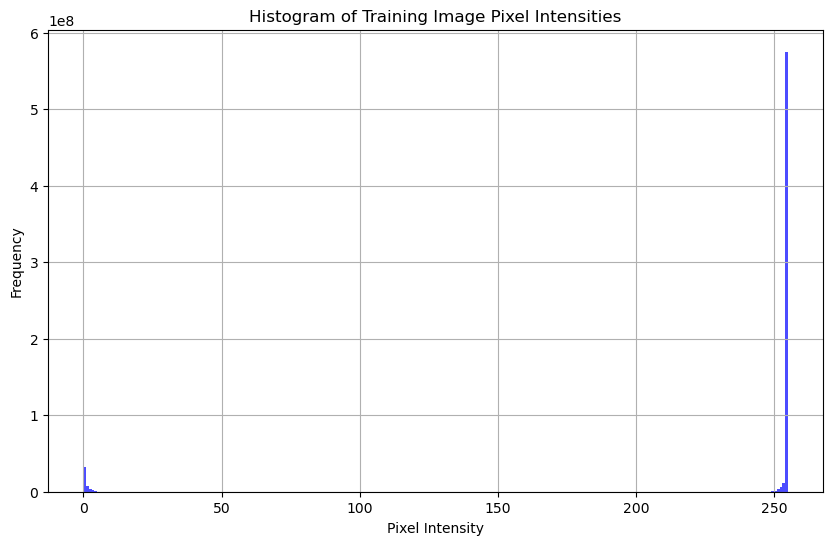

Everything set!


In [2]:
path = '/home/valenpaz22/QuickDraw-10/'
    
mapping, train_data, test_data = load_images(path);
    
train_image_paths = [os.path.join(path, item[0]) for item in train_data]
train_labels = [int(item[1]) for item in train_data]
test_image_paths = [os.path.join(path, item[0]) for item in test_data]
test_labels = [int(item[1]) for item in test_data]
    
reverse_mapping = {
    0: 'sink',
    1: 'castle',
    2: 'lion',
    3: 'teapot',
    4: 'flashlight',
    5: 'blackberry',
    6: 'spreadsheet',
    7: 'bandage',
    8: 'remote-control',
    9: 'trombone'
}
    
train_labels_strings = [reverse_mapping[label] for label in train_labels]
test_labels_strings = [reverse_mapping[label] for label in test_labels]

print("Preprocessing images...")
train_images = preprocess_images(train_image_paths)
test_images = preprocess_images(test_image_paths)
    
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images)
test_images_scaled = scaler.transform(test_images)
              
print("Using scaler...")
    
kernels = ['rbf', 'poly']
feature_sets = {
    'Raw Vectors': train_images_scaled,
    'PCA': PCA(n_components=256).fit_transform(train_images_scaled),
    'UMAP': umap.UMAP(n_components=256).fit_transform(train_images_scaled)
}

print("Defining images for tuning hyperparameters...")
   
tune_train_images, tune_train_images_labels = load_and_preprocess_images_for_tuning(train_data, path, 100)
    
scaler = StandardScaler()
tune_train_images_scaled = scaler.fit_transform(tune_train_images)
    
print("Using scaler on the images for tuning hyperparameters...")    
feature_sets_tune = {
    'Raw Vectors': tune_train_images_scaled,
    'PCA': PCA(n_components=256).fit_transform(tune_train_images_scaled),
    'UMAP': umap.UMAP(n_components=256).fit_transform(tune_train_images_scaled)
}

Creating histograms...


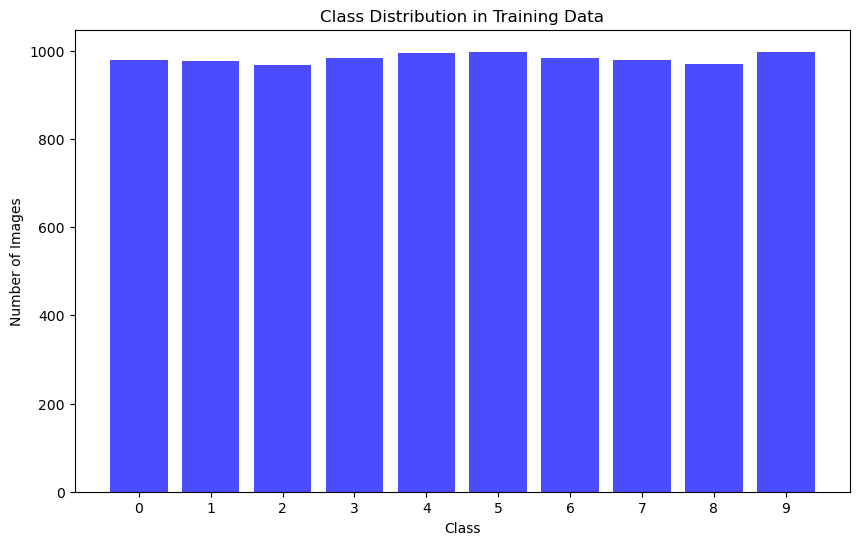

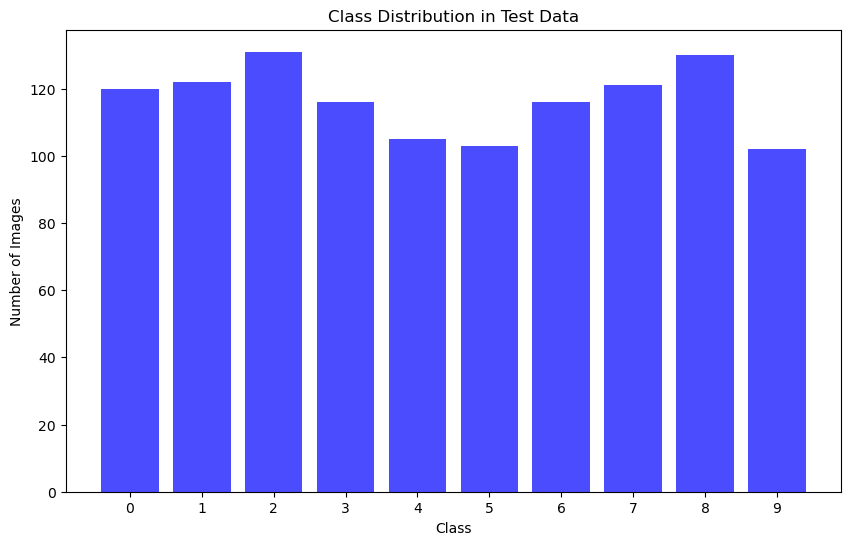

Everything set!


In [8]:
print("Creating histograms...")
plot_class_distribution(train_labels, num_classes=10, title="Class Distribution in Training Data")

plot_class_distribution(test_labels, num_classes=10, title="Class Distribution in Test Data")
print("Everything set!")


Training SVM with RBF kernel on Raw Vectors
Training time for rbf kernel: 1832.7339 seconds
SVM RBF + Raw Vectors: 0.7170
Accuracy per class: [0.6929133858267716, 0.6639344262295082, 0.7647058823529411, 0.8017241379310345, 0.656, 0.68, 0.6736111111111112, 0.8252427184466019, 0.824, 0.5980392156862745]


<Figure size 800x600 with 0 Axes>

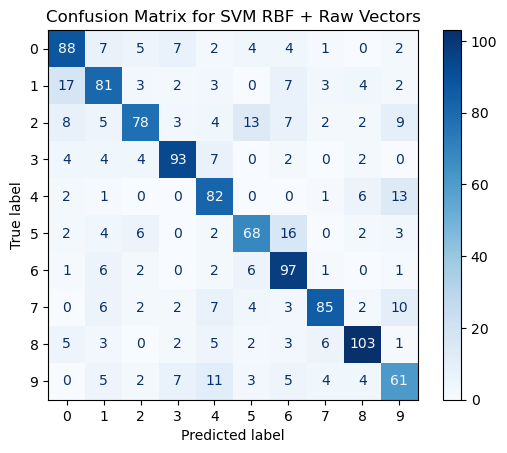

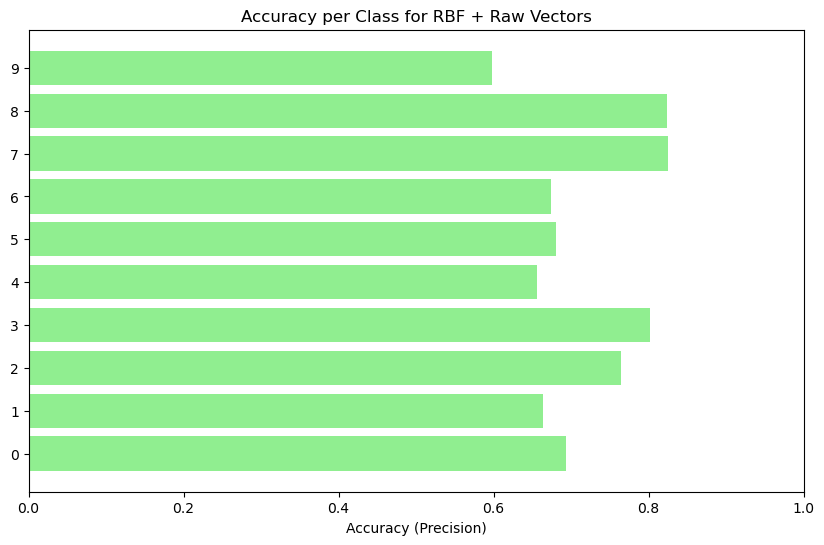

In [15]:
# Train and evaluate models separately for each kernel and feature set combination
# 1. RBF + Raw Vectors
print("\nTraining SVM with RBF kernel on Raw Vectors")
best_model_rbf_raw, accuracy_rbf_raw, predictions_rbf_raw = train_svm_model(
    train_images_scaled, train_labels, test_images_scaled, test_labels, kernel='rbf', C=1.0, gamma='scale', degree=3
)

predictions_strings_rbf_raw = [reverse_mapping[pred] for pred in predictions_rbf_raw]
test_labels_strings_rbf_raw = [reverse_mapping[label] for label in test_labels]
accuracy_rbf_raw = accuracy_score(test_labels, predictions_rbf_raw)
print(f"SVM RBF + Raw Vectors: {accuracy_rbf_raw:.4f}")
print(classification_report(test_labels_strings_rbf_raw, predictions_strings_rbf_raw))

# Extract accuracy for each class from classification report
report_rbf_raw = classification_report(test_labels, predictions_rbf_raw, output_dict=True)
class_names = list(report_rbf_raw.keys())[:-3]
accuracies_rbf_raw = [report_rbf_raw[class_name]['precision'] for class_name in class_names]
plot_confusion_matrix_for_model(predictions_rbf_raw, test_labels, train_labels_strings, "SVM RBF + Raw Vectors")


Accuracy per class: [0.6929133858267716, 0.6639344262295082, 0.7647058823529411, 0.8017241379310345, 0.656, 0.68, 0.6736111111111112, 0.8252427184466019, 0.824, 0.5980392156862745]


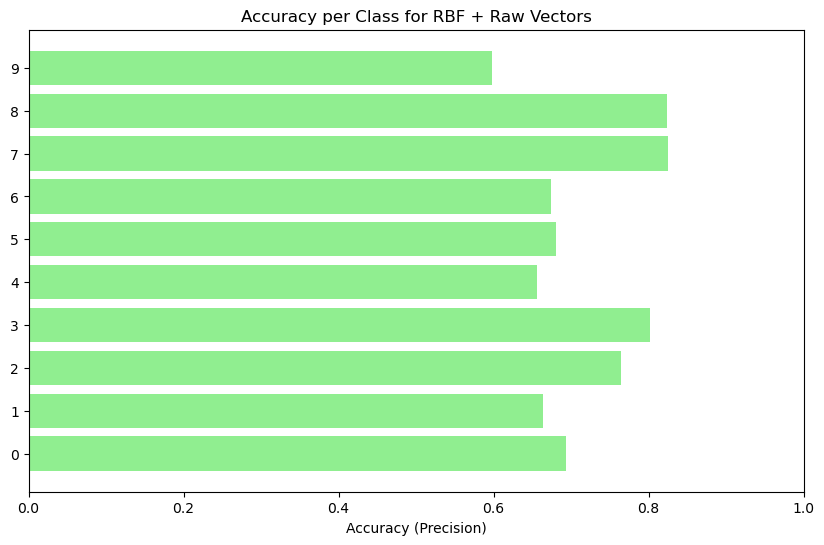

In [23]:
print("Accuracy per class:", accuracies_rbf_raw)
plot_accuracy_per_class(class_names, accuracies_rbf_raw, "RBF + Raw Vectors")


Training SVM with RBF kernel on PCA features
Training time for rbf kernel: 5.4187 seconds
SVM RBF + PCA: 0.7710
                precision    recall  f1-score   support

       bandage       0.90      0.78      0.83       121
    blackberry       0.75      0.71      0.73       103
        castle       0.75      0.75      0.75       122
    flashlight       0.66      0.90      0.76       105
          lion       0.74      0.73      0.73       131
remote-control       0.85      0.82      0.83       130
          sink       0.76      0.75      0.75       120
   spreadsheet       0.88      0.77      0.82       116
        teapot       0.88      0.84      0.86       116
      trombone       0.61      0.67      0.64       102

      accuracy                           0.77      1166
     macro avg       0.78      0.77      0.77      1166
  weighted avg       0.78      0.77      0.77      1166



<Figure size 800x600 with 0 Axes>

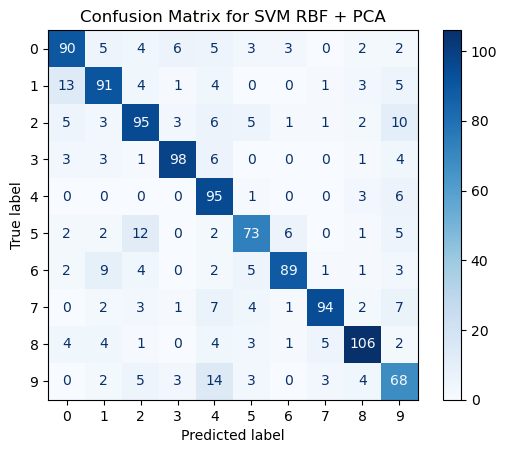

Accuracy per class: [0.8952380952380953, 0.7525773195876289, 0.7520661157024794, 0.6551724137931034, 0.7364341085271318, 0.848, 0.7563025210084033, 0.8811881188118812, 0.875, 0.6071428571428571]


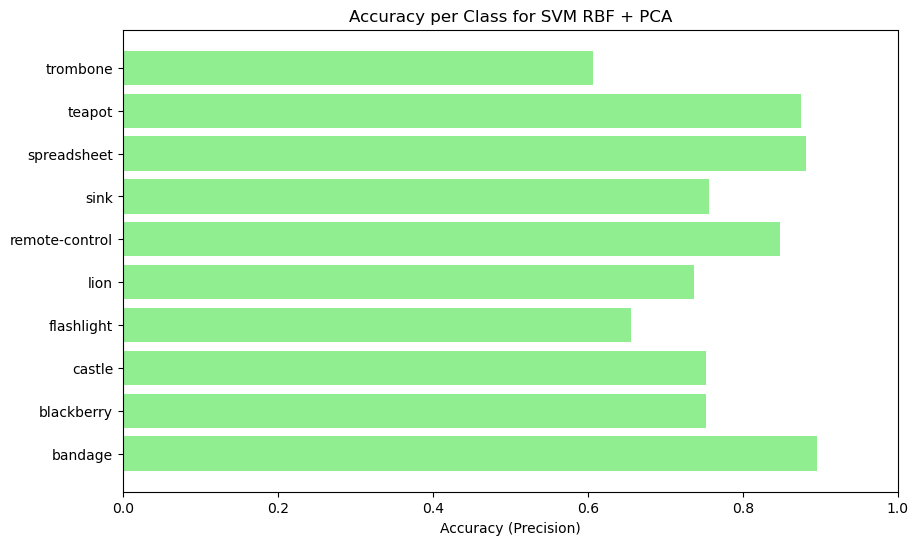

In [40]:
# 2. RBF + PCA
print("\nTraining SVM with RBF kernel on PCA features")

# Fit PCA on training data and then transform both train and test data
pca = PCA(n_components=256)
train_pca = pca.fit_transform(train_images_scaled)  # Fit PCA on training data
test_pca = pca.transform(test_images_scaled)  # Apply the same transformation to test data

best_model_rbf_pca, accuracy_rbf_pca, predictions_rbf_pca = train_svm_model(
    train_pca, train_labels,
    test_pca, test_labels, kernel='rbf', C=1.0, gamma='scale', degree=3
)

# Convert predictions and test labels to string labels
predictions_strings_rbf_pca = [reverse_mapping[pred] for pred in predictions_rbf_pca]
test_labels_strings_rbf_pca = [reverse_mapping[label] for label in test_labels]
accuracy_rbf_pca = accuracy_score(test_labels_strings_rbf_pca, predictions_strings_rbf_pca)
print(f"SVM RBF + PCA: {accuracy_rbf_pca:.4f}")
print(classification_report(test_labels_strings_rbf_pca, predictions_strings_rbf_pca))
plot_confusion_matrix_for_model(predictions_rbf_pca, test_labels, train_labels_strings, "SVM RBF + PCA")

# Extract accuracy for each class from classification report
report_rbf_pca = classification_report(test_labels_strings_rbf_pca, predictions_strings_rbf_pca, output_dict=True)
class_names = list(report_rbf_pca.keys())[:-3]
accuracies_rbf_pca = [report_rbf_pca[class_name]['precision'] for class_name in class_names]
print("Accuracy per class:", accuracies_rbf_pca)
plot_accuracy_per_class(class_names, accuracies_rbf_pca, "SVM RBF + PCA")


Training SVM with RBF kernel on UMAP features
Training time for rbf kernel: 5.6650 seconds
SVM RBF + UMAP: 0.2976
                precision    recall  f1-score   support

       bandage       0.50      0.45      0.47       121
    blackberry       0.27      0.41      0.33       103
        castle       0.59      0.11      0.18       122
    flashlight       0.00      0.00      0.00       105
          lion       0.19      0.89      0.31       131
remote-control       0.66      0.52      0.58       130
          sink       0.00      0.00      0.00       120
   spreadsheet       0.33      0.22      0.26       116
        teapot       0.75      0.03      0.05       116
      trombone       0.31      0.25      0.28       102

      accuracy                           0.30      1166
     macro avg       0.36      0.29      0.25      1166
  weighted avg       0.37      0.30      0.25      1166



<Figure size 800x600 with 0 Axes>

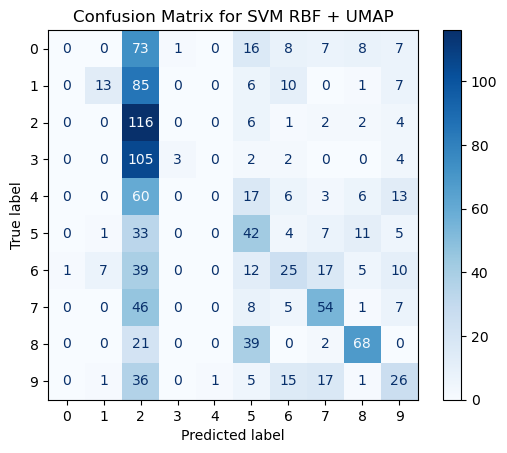

Accuracy per class: [0.4954128440366973, 0.27450980392156865, 0.5909090909090909, 0.0, 0.18892508143322476, 0.6601941747572816, 0.0, 0.32894736842105265, 0.75, 0.3132530120481928]


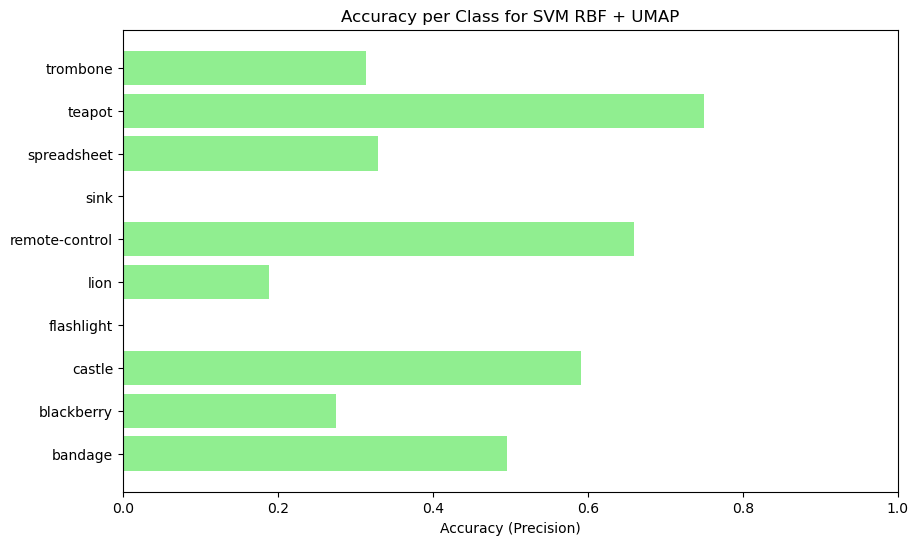

In [41]:
# 3. RBF + UMAP
print("\nTraining SVM with RBF kernel on UMAP features")

# Fit UMAP on training data and then transform both train and test data
umap_model = umap.UMAP(n_components=256)
train_umap = umap_model.fit_transform(train_images_scaled)  # Fit UMAP on training data
test_umap = umap_model.transform(test_images_scaled)  # Apply the same transformation to test data

best_model_rbf_umap, accuracy_rbf_umap, predictions_rbf_umap = train_svm_model(
    train_umap, train_labels,
    test_umap, test_labels, kernel='rbf', C=1.0, gamma='scale', degree=3
)

predictions_strings_rbf_umap = [reverse_mapping[pred] for pred in predictions_rbf_umap]
test_labels_strings_rbf_umap = [reverse_mapping[label] for label in test_labels]
accuracy_rbf_umap = accuracy_score(test_labels_strings_rbf_umap, predictions_strings_rbf_umap)
print(f"SVM RBF + UMAP: {accuracy_rbf_umap:.4f}")
print(classification_report(test_labels_strings_rbf_umap, predictions_strings_rbf_umap))
plot_confusion_matrix_for_model(predictions_rbf_umap, test_labels, train_labels_strings, "SVM RBF + UMAP")

report_rbf_umap = classification_report(test_labels_strings_rbf_umap, predictions_strings_rbf_umap, output_dict=True)
class_names = list(report_rbf_umap.keys())[:-3]  # Exclude avg/total fields
accuracies_rbf_umap = [report_rbf_umap[class_name]['precision'] for class_name in class_names]
print("Accuracy per class:", accuracies_rbf_umap)
plot_accuracy_per_class(class_names, accuracies_rbf_umap, "SVM RBF + UMAP")

In [ ]:
# 4. Polynomial + Raw Vectors
print("\nTraining SVM with Polynomial kernel on Raw Vectors")
best_model_poly_raw, accuracy_poly_raw, predictions_poly_raw = train_svm_model(
    train_images_scaled, train_labels, test_images_scaled, test_labels, kernel='poly', C=1.0, gamma='scale', degree=3
)

predictions_strings_poly_raw = [reverse_mapping[pred] for pred in predictions_poly_raw]
test_labels_strings_poly_raw = [reverse_mapping[label] for label in test_labels]
accuracy_poly_raw = accuracy_score(test_labels_strings_poly_raw, predictions_strings_poly_raw)
print(f"SVM Polynomial + Raw Vectors: {accuracy_poly_raw:.4f}")
print(classification_report(test_labels_strings_poly_raw, predictions_strings_poly_raw))
plot_confusion_matrix_for_model(predictions_poly_raw, test_labels, train_labels_strings, "SVM Polynomial + Raw Vectors")

report_poly_raw = classification_report(test_labels_strings_poly_raw, predictions_strings_poly_raw, output_dict=True)
class_names = list(report_poly_raw.keys())[:-3]
accuracies_poly_raw = [report_poly_raw[class_name]['precision'] for class_name in class_names]
print("Accuracy per class:", accuracies_poly_raw)
plot_accuracy_per_class(class_names, accuracies_poly_raw, "SVM Polynomial + Raw Vectors")


Training SVM with Polynomial kernel on PCA features
Training time for poly kernel: 8.3963 seconds
SVM Polynomial + PCA: 0.6252
                precision    recall  f1-score   support

       bandage       0.97      0.63      0.76       121
    blackberry       0.84      0.60      0.70       103
        castle       0.80      0.57      0.67       122
    flashlight       0.27      0.95      0.43       105
          lion       0.70      0.48      0.57       131
remote-control       0.89      0.69      0.78       130
          sink       0.84      0.53      0.65       120
   spreadsheet       0.94      0.54      0.69       116
        teapot       0.65      0.84      0.73       116
      trombone       0.56      0.43      0.49       102

      accuracy                           0.63      1166
     macro avg       0.75      0.63      0.65      1166
  weighted avg       0.76      0.63      0.65      1166



<Figure size 800x600 with 0 Axes>

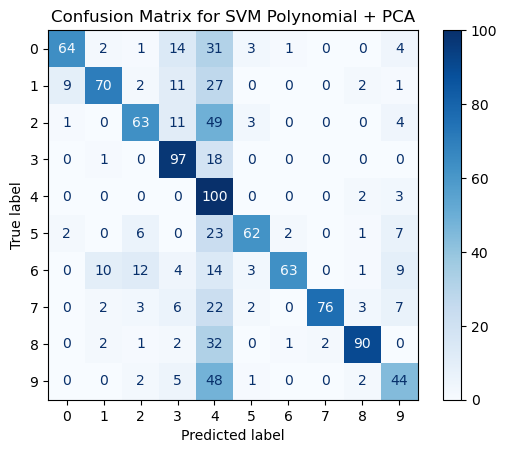

Accuracy per class: [0.9743589743589743, 0.8378378378378378, 0.8045977011494253, 0.27472527472527475, 0.7, 0.8910891089108911, 0.8421052631578947, 0.9402985074626866, 0.6466666666666666, 0.5569620253164557]


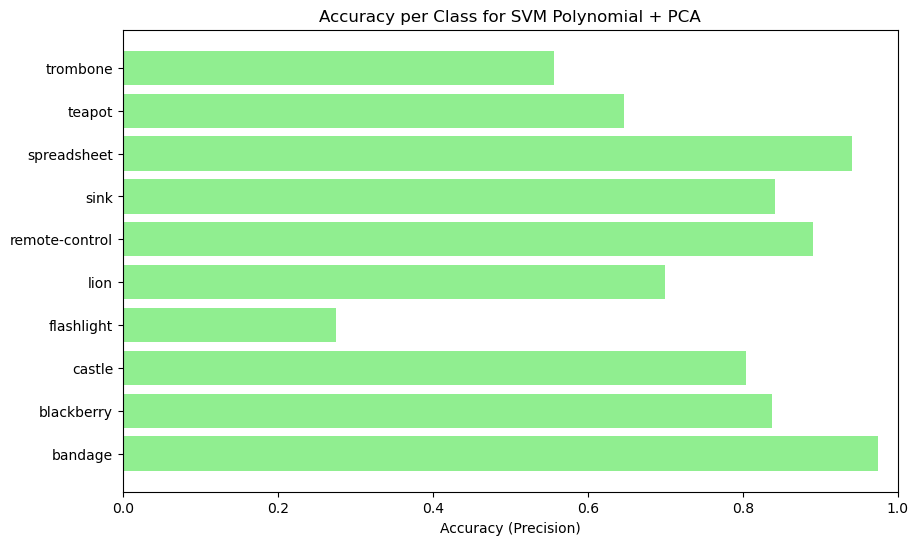

In [4]:
# 5. Polynomial + PCA
print("\nTraining SVM with Polynomial kernel on PCA features")

pca = PCA(n_components=256)
train_pca = pca.fit_transform(train_images_scaled)  # Fit PCA on training data
test_pca = pca.transform(test_images_scaled)  # Apply the same transformation to test data

best_model_poly_pca, accuracy_poly_pca, predictions_poly_pca = train_svm_model(
    train_pca, train_labels,
    test_pca, test_labels, kernel='poly', C=1.0, gamma='scale', degree=3
)

predictions_strings_poly_pca = [reverse_mapping[pred] for pred in predictions_poly_pca]
test_labels_strings_poly_pca = [reverse_mapping[label] for label in test_labels]
accuracy_poly_pca = accuracy_score(test_labels_strings_poly_pca, predictions_strings_poly_pca)
print(f"SVM Polynomial + PCA: {accuracy_poly_pca:.4f}")
print(classification_report(test_labels_strings_poly_pca, predictions_strings_poly_pca))
plot_confusion_matrix_for_model(predictions_poly_pca, test_labels, train_labels_strings, "SVM Polynomial + PCA")

# Extract accuracy for each class from classification report
report_poly_pca = classification_report(test_labels_strings_poly_pca, predictions_strings_poly_pca, output_dict=True)
class_names = list(report_poly_pca.keys())[:-3]  # Exclude avg/total fields
accuracies_poly_pca = [report_poly_pca[class_name]['precision'] for class_name in class_names]
print("Accuracy per class:", accuracies_poly_pca)
plot_accuracy_per_class(class_names, accuracies_poly_pca, "SVM Polynomial + PCA")


Training SVM with Polynomial kernel on UMAP features
Training time for poly kernel: 3.0633 seconds
SVM Polynomial + UMAP: 0.2770
                precision    recall  f1-score   support

       bandage       0.53      0.50      0.51       121
    blackberry       0.40      0.35      0.38       103
        castle       0.61      0.11      0.19       122
    flashlight       0.23      0.03      0.05       105
          lion       0.17      0.85      0.28       131
remote-control       0.77      0.25      0.38       130
          sink       0.15      0.02      0.03       120
   spreadsheet       0.50      0.13      0.21       116
        teapot       0.60      0.03      0.05       116
      trombone       0.26      0.45      0.33       102

      accuracy                           0.28      1166
     macro avg       0.42      0.27      0.24      1166
  weighted avg       0.43      0.28      0.24      1166



<Figure size 800x600 with 0 Axes>

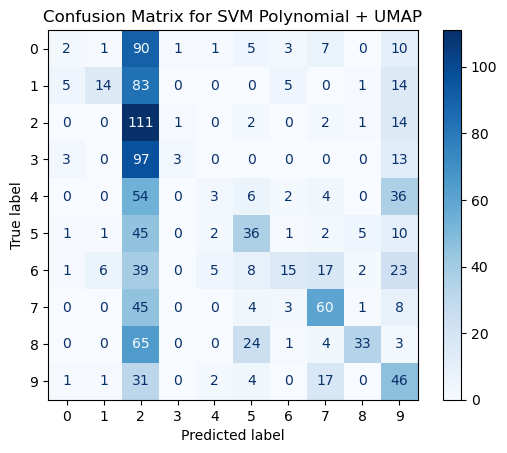

Accuracy per class: [0.5309734513274337, 0.4044943820224719, 0.6086956521739131, 0.23076923076923078, 0.16818181818181818, 0.7674418604651163, 0.15384615384615385, 0.5, 0.6, 0.2598870056497175]


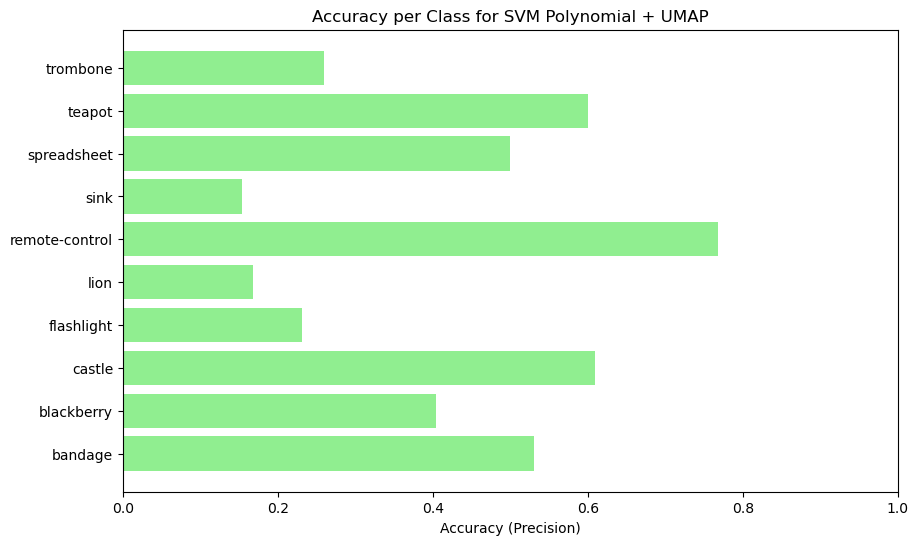

In [5]:
# 6. Polynomial + UMAP
print("\nTraining SVM with Polynomial kernel on UMAP features")

umap_model = umap.UMAP(n_components=256)
train_umap = umap_model.fit_transform(train_images_scaled)  # Fit UMAP on training data
test_umap = umap_model.transform(test_images_scaled)  # Apply the same transformation to test data

best_model_poly_umap, accuracy_poly_umap, predictions_poly_umap = train_svm_model(
    train_umap, train_labels,
    test_umap, test_labels, kernel='poly', C=1.0, gamma='scale', degree=3
)

predictions_strings_poly_umap = [reverse_mapping[pred] for pred in predictions_poly_umap]
test_labels_strings_poly_umap = [reverse_mapping[label] for label in test_labels]
accuracy_poly_umap = accuracy_score(test_labels_strings_poly_umap, predictions_strings_poly_umap)
print(f"SVM Polynomial + UMAP: {accuracy_poly_umap:.4f}")
print(classification_report(test_labels_strings_poly_umap, predictions_strings_poly_umap))
plot_confusion_matrix_for_model(predictions_poly_umap, test_labels, train_labels_strings, "SVM Polynomial + UMAP")

report_poly_umap = classification_report(test_labels_strings_poly_umap, predictions_strings_poly_umap, output_dict=True)
class_names = list(report_poly_umap.keys())[:-3]  # Exclude avg/total fields
accuracies_poly_umap = [report_poly_umap[class_name]['precision'] for class_name in class_names]
print("Accuracy per class:", accuracies_poly_umap)
plot_accuracy_per_class(class_names, accuracies_poly_umap, "SVM Polynomial + UMAP")


In [6]:
# Tuning SVM hyperparameters for RBF kernel + Raw Vectors
print("\nTuning SVM hyperparameters with RBF kernel on Raw Vectors features")
best_model_rbf_raw_tune, best_params_rbf_raw, best_score_rbf_raw = tune_svm_hyperparameters(
    tune_train_images_scaled, tune_train_images_labels, test_images_scaled, test_labels, kernel='rbf', param_range=None, cv=5
)


Tuning SVM hyperparameters with RBF kernel on Raw Vectors features
Hyperparameter tuning time for rbf kernel: 1104.1043 seconds
Best Score (accuracy) with rbf kernel: 0.576
Best Hyperparameters with rbf kernel: {'C': 10.0, 'gamma': 'scale'}
Test Accuracy with Best Model: 0.6166


In [10]:
# Tuning SVM hyperparameters for RBF kernel + PCA
print("\nTuning SVM hyperparameters with RBF kernel on PCA features")

pca = PCA(n_components=256)
train_pca = pca.fit_transform(tune_train_images_scaled) 
test_pca = pca.transform(test_images_scaled) 

best_model_rbf_pca_tune, best_params_rbf_pca, best_score_rbf_pca = tune_svm_hyperparameters(
    train_pca, tune_train_images_labels, test_pca, test_labels, kernel='rbf', param_range=None, cv=5
)



Tuning SVM hyperparameters with RBF kernel on PCA features
Hyperparameter tuning time for rbf kernel: 4.3661 seconds
Best Score (accuracy) with rbf kernel: 0.5780000000000001
Best Hyperparameters with rbf kernel: {'C': 10.0, 'gamma': 'scale'}
Test Accuracy with Best Model: 0.5969


In [11]:
# Tuning SVM hyperparameters for RBF kernel + UMAP
print("\nTuning SVM hyperparameters with RBF kernel on UMAP features")

umap_model = umap.UMAP(n_components=256)
train_umap = umap_model.fit_transform(tune_train_images_scaled)  # Fit and transform the training data
test_umap = umap_model.transform(test_images_scaled)  # Transform the test data using the fitted UMAP model

best_model_rbf_umap_tune, best_params_rbf_umap, best_score_rbf_umap = tune_svm_hyperparameters(
    train_umap, tune_train_images_labels, test_umap, test_labels, kernel='rbf', param_range=None, cv=5
)



Tuning SVM hyperparameters with RBF kernel on UMAP features
Hyperparameter tuning time for rbf kernel: 2.2293 seconds
Best Score (accuracy) with rbf kernel: 0.658
Best Hyperparameters with rbf kernel: {'C': 100.0, 'gamma': 0.1}
Test Accuracy with Best Model: 0.2633


In [12]:
# Tuning SVM hyperparameters for Polynomial kernel + Raw Vectors
print("\nTuning SVM hyperparameters with Polynomial kernel on Raw Vectors features")
best_model_poly_raw_tune, best_params_poly_raw, best_score_poly_raw = tune_svm_hyperparameters(
    tune_train_images_scaled, tune_train_images_labels, test_images_scaled, test_labels, kernel='poly', param_range=None, cv=5
)


Tuning SVM hyperparameters with Polynomial kernel on Raw Vectors features
Hyperparameter tuning time for poly kernel: 1031.3509 seconds
Best Score (accuracy) with poly kernel: 0.16699999999999998
Best Hyperparameters with poly kernel: {'C': 1.0, 'degree': 3, 'gamma': 0.001}
Test Accuracy with Best Model: 0.1750


In [13]:
# Tuning SVM hyperparameters for Polynomial kernel + PCA
print("\nTuning SVM hyperparameters with Polynomial kernel on PCA features")

pca = PCA(n_components=256)
train_pca = pca.fit_transform(tune_train_images_scaled)  # Fit and transform the training data
test_pca = pca.transform(test_images_scaled)  # Transform the test data using the fitted PCA model

best_model_poly_pca_tune, best_params_poly_pca, best_score_poly_pca = tune_svm_hyperparameters(
    train_pca, tune_train_images_labels, test_pca, test_labels, kernel='poly', param_range=None, cv=5
)



Tuning SVM hyperparameters with Polynomial kernel on PCA features
Hyperparameter tuning time for poly kernel: 2.7284 seconds
Best Score (accuracy) with poly kernel: 0.29700000000000004
Best Hyperparameters with poly kernel: {'C': 1.0, 'degree': 3, 'gamma': 0.001}
Test Accuracy with Best Model: 0.2581


In [14]:
# Tuning SVM hyperparameters for Polynomial kernel + UMAP
print("\nTuning SVM hyperparameters with Polynomial kernel on UMAP features")

umap_model = umap.UMAP(n_components=256)
train_umap = umap_model.fit_transform(tune_train_images_scaled)  # Fit and transform the training data
test_umap = umap_model.transform(test_images_scaled)  # Transform the test data using the fitted UMAP model

best_model_poly_umap_tune, best_params_poly_umap, best_score_poly_umap = tune_svm_hyperparameters(
    train_umap, tune_train_images_labels, test_umap, test_labels, kernel='poly', param_range=None, cv=5
)


Tuning SVM hyperparameters with Polynomial kernel on UMAP features
Hyperparameter tuning time for poly kernel: 27.6842 seconds
Best Score (accuracy) with poly kernel: 0.632
Best Hyperparameters with poly kernel: {'C': 1.0, 'degree': 3, 'gamma': 'scale'}
Test Accuracy with Best Model: 0.2993


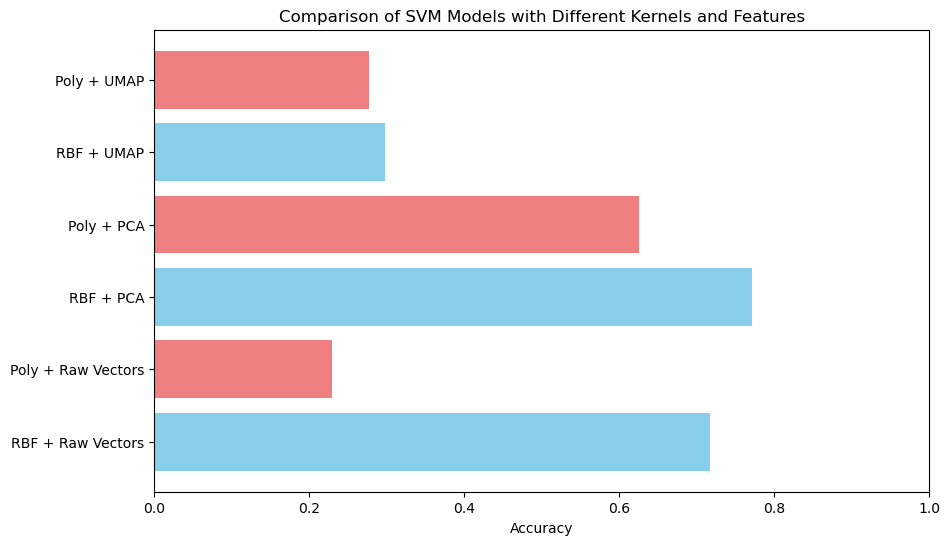

In [3]:
# Plot accuracies by types of images
accuracies = [
    0.7170 , 0.2290, 
    0.7710, 0.6252, 
    0.2976, 0.2770
]

# 3. Create a bar plot to compare accuracies
model_names = [
    "RBF + Raw Vectors", "Poly + Raw Vectors", 
    "RBF + PCA", "Poly + PCA", 
    "RBF + UMAP", "Poly + UMAP"
]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies, color=['skyblue', 'lightcoral', 'skyblue', 'lightcoral', 'skyblue', 'lightcoral'])

plt.xlabel('Accuracy')
plt.title('Comparison of SVM Models with Different Kernels and Features')
plt.xlim(0, 1)  
plt.show()
